In [1]:
import pandas as pd
import numpy as np
from statistics import mode
import re
from collections import defaultdict
from ortoolpy import model_min, addbinvars
from itertools import product, combinations


od_matrix = pd.read_csv('./data/Sample_OD_Matrix.csv', index_col= 0)
od_matrix.head()

orders = pd.read_csv('./data/Sample_InputData.csv')
orders

start_location = od_matrix.index[0]

rack_capacity = 2

> ### MIP

In [5]:
# 빈도 / 거리 / 공동 주문 연관성 정규화

skus = orders['SKU_CD'].unique().tolist()
racks = od_matrix.index[2:].tolist()

freq = orders['SKU_CD'].value_counts().to_dict() # sku별 빈도
freq_max = max(freq.values())
standard_freq_dict = {sku: f / freq_max for sku, f in freq.items()}

sku_to_orders = orders.groupby('SKU_CD')['ORD_NO'].apply(set).to_dict()
cooc = {
    (a, b): len(sku_to_orders[a] & sku_to_orders[b]) / len(sku_to_orders[a] | sku_to_orders[b])
    for a, b in combinations(sku_to_orders.keys(), 2)
}

cooc_unique = {}
seen = set()

for (a, b), sim in cooc.items():
    key = tuple(sorted([a, b]))  # (A, B)나 (B, A) → 항상 (A, B)로 정렬
    if a != b and key not in seen:  # 자기 자신은 제외
        cooc_unique[key] = sim
        seen.add(key)

cooc = cooc_unique

standard_od_matrix = od_matrix / od_matrix.values.max()

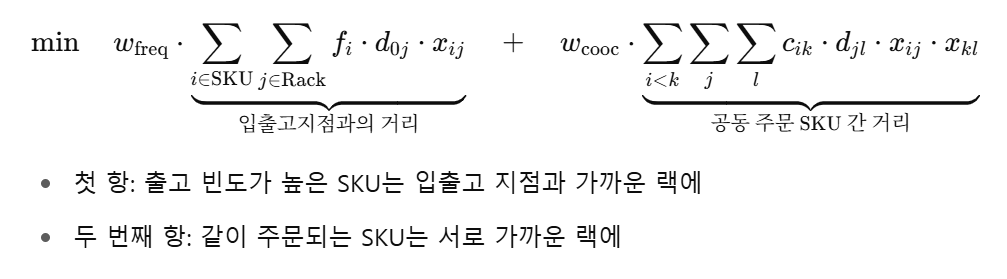

In [ ]:
m = model_min()

# x[i][j] : SKU i가 랙 j에 배치되는지
# vtype : 이진 변수('B')
x = addbinvars(len(skus), len(racks))

sku_idx = {sku: i for i, sku in enumerate(skus)}
rack_idx = {rack: j for j, rack in enumerate(racks)}

# 빈도 기반 비용(입출고 지점에서 가까운 랙에 고빈도 SKU 배치)
freq_cost = sum(
  standard_freq_dict[sku] * standard_od_matrix.loc[start_location, rack] * x[sku_idx[sku]][rack_idx[rack]]
  for sku in skus for rack in racks
)

z_vars = []
cooc_cost_terms = []
# 공동 주문 연관성 기반 비용(연관성 높은 SKU들이 가까운 랙에 배치)
# 같이 주문된 SKU 간 거리 최소화
for (sku1, sku2), sim in cooc.items():
    i1, i2 = sku_idx[sku1], sku_idx[sku2]
    for rack1 in racks:
        j1 = rack_idx[rack1]
        for rack2 in racks:
            j2 = rack_idx[rack2]

            # 새로운 이진 변수 z
            z = addbinvars(1)[0]  # 이진 변수
            z_vars.append(z)

            # 제약조건 (선형화)
            m += z <= x[i1][j1]
            m += z <= x[i2][j2]
            m += z >= x[i1][j1] + x[i2][j2] - 1

            # 공동 거리 비용 반영
            cost = sim * standard_od_matrix.loc[rack1, rack2]
            cooc_cost_terms.append(cost * z)

w_freq = 0.5
w_cooc = 0.5
cooc_cost = sum(cooc_cost_terms)
m.setObjective(w_freq * freq_cost + w_cooc * cooc_cost)

# 제약조건1 : 각 SKU는 정확히 하나의 랙에 배치
for i in range(len(skus)) :
  m.addConstr(sum(x[i][j] for j in range(len(racks))) == 1)
  
rack_capacity = 2  
# 제약조건2 : 각 랙에는 최대 2개의 SKU만 배치
for j in range(len(racks)) :
  m.addConstr(sum(x[i][j] for i in range(len(skus))) <= rack_capacity)

m.optimize()


AttributeError: 'LpProblemEx' object has no attribute 'addVar'

In [ ]:
sku_to_loc = {}
for sku, i in sku_idx.items() :
  for rack, j in rack_idx.items() :
    if x[i][j].X > 0.5 : # 0.5보다 크면 이진변수 1로 랙에 배치된것을 의미
      sku_to_loc[sku] = rack
      break

orders['LOC'] = orders['SKU_CD'].map(sku_to_loc)


> ### Hybrid SLAP

In [ ]:
# 1) 상위 20% SKU를 출고빈도 기준으로 정렬
# 2) 빈도순으로 차례로 꺼내고
# - 자신이 입고지에서 가장 가까운 랙을 먼저 선점
# - 공동 주문된 SKU들을 현재 랙 근처 가장 가까운 랙으로 Greedy 재배치

# 남은 SKU 중애 공동 주문된 SKU가 이미 배치되어 있다면
# 해당 랙 근처로 그리디 배치 
# 남은 랙, 남은 SKU에 대해서는 빈도수 기반으로 입출고 지점과 가깝게 배치

In [ ]:
sku_freq = orders['SKU_CD'].value_counts()
top_k =int(len(sku_freq) * 0.2)
top_skus = sku_freq.head(top_k).index.tolist()

# {SKU : {ORD, ,,}}
sku_orders = orders.groupby('SKU_CD')['ORD_NO'].apply(set).to_dict()
# sku_orders

cooc_sku_map = defaultdict(set)
for a in top_skus :
  for b in sku_orders :
    if a == b :
      continue
    # 등장했던 주문 중 몇 번이나 함께 등장했는지
    inter = sku_orders[a] & sku_orders[b]
    # a와 b가 등장했던 총 주문
    union = sku_orders[a] | sku_orders[b]
    if union and len(inter) > 0 :
      cooc_sku_map[a].add(b)

# {빈도 높은 SKU : {함께 등장한 적 있는 SKU}}
# cooc_sku_map
    
racks = od_matrix.index[2:]
start_to_rack_dists=  od_matrix.loc[od_matrix.index[0], racks]
rack_sorted = start_to_rack_dists.sort_values().index.tolist()

assigned_skus = set()
# {rack : count}
rack_assign_count = {rack: 0 for rack in rack_sorted}
sku_to_loc = {}

# step1 : 상위 20% SKU 입출고 지점 + 공동 주문 SKU 가까이 배치
# 상위 20% SKU 입출고 지점 우선 배치
for sku in top_skus :
  if sku in assigned_skus :
    continue
  
  for rack in rack_sorted :
    if rack_assign_count[rack] < rack_capacity :
      sku_to_loc[sku] = rack
      assigned_skus.add(sku)
      rack_assign_count[rack] += 1
      base_rack = rack
      break
  
  # 공동 주문된 SKU들 가까이 배치
  neighbors = cooc_sku_map[sku]
  if not neighbors :
    continue
  
  # 기준 랙과의 거리
  base_rack_dist = od_matrix.loc[base_rack, racks]
  near_racks_sorted = base_rack_dist.sort_values().index.tolist()
  
  for nb_sku in neighbors :
    if nb_sku in assigned_skus :
      continue
    for rack in near_racks_sorted :
      if rack_assign_count[rack] < rack_capacity :
        sku_to_loc[nb_sku] = rack
        assigned_skus.add(nb_sku)
        rack_assign_count[rack] += 1
        break
      
# Step2 : 이미 배치되어 있는 sku와 공동 주문된 sku가 있다면 근처 배치
remaining_skus = [s for s in sku_freq.index if s not in assigned_skus]
for remained_sku in remaining_skus :
  # {ORD, ORD, ,,} - remaining_sku별 등장한 주문 목록
  remained_sku_orders = sku_orders.get(remained_sku, set())
  co_ordered_assigned_locs = []
  for assigned_sku in sku_to_loc :
    if assigned_sku == remained_sku :
      continue
    # 공동 주문된 ORD가 있다면
    if remained_sku_orders & sku_orders[assigned_sku] :
      co_ordered_assigned_locs.append(sku_to_loc[assigned_sku])
  
  # remaining_sku가 이미 배치된 SKU와 공동 주문된 SKU가 있다면
  # {RACK, RACK, ,,}
  if co_ordered_assigned_locs :
    # 공동 주문된 SKU의 LOC까지의 평균 거리
    # RACK_1 : 33, ,, ~ RACK_168 : 26
    avg_dist = od_matrix.loc[racks, co_ordered_assigned_locs].mean(axis= 1)
    candidate_racks = avg_dist.sort_values().index.tolist()
  # remaining_sku가 공동 주문된 SKU가 없다면
  else :
    candidate_racks = rack_sorted
  
  for rack in candidate_racks :
    if rack_assign_count[rack] < rack_capacity :
      sku_to_loc[sku] = rack
      rack_assign_count[rack] += 1
      break


In [ ]:
def assign_sku_to_rack_greedy(orders, od_matrix, rack_capacity=2, top_percent=0.2):
    sku_freq = orders['SKU_CD'].value_counts()
    top_k = int(len(sku_freq) * top_percent)
    top_skus = sku_freq.head(top_k).index.tolist()

    # SKU별 주문 번호 집합
    # {SKU: {ORD_NO, ...}}
    sku_orders = orders.groupby('SKU_CD')['ORD_NO'].apply(set).to_dict()

    # 공동 주문 SKU: 자카드 유사도 > 0
    cooc_sku_map = defaultdict(set)
    for a in top_skus:
        for b in sku_orders:
            if a == b:
                continue
            inter = sku_orders[a] & sku_orders[b]
            union = sku_orders[a] | sku_orders[b]
            if union and len(inter) > 0:
                cooc_sku_map[a].add(b)

    racks = od_matrix.index[2:]  # oWP_Start, oWP_End 제외
    rack_dists = od_matrix.loc[od_matrix.index[0], racks]  # 입고지 기준
    rack_sorted = rack_dists.sort_values().index.tolist()

    assigned_skus = set()
    # {RACK : count}
    rack_assign_count = {rack: 0 for rack in rack_sorted}
    sku_to_loc = {}

    # Step 1: 상위 20% SKU + 공동 주문 SKU 배치
    for sku in top_skus:
        if sku in assigned_skus:
            continue

        # 본인 먼저 배치
        for rack in rack_sorted:
            if rack_assign_count[rack] < rack_capacity:
                sku_to_loc[sku] = rack
                assigned_skus.add(sku)
                rack_assign_count[rack] += 1
                base_rack = rack
                break

        # 공동 주문된 SKU들 배치
        neighbors = cooc_sku_map[sku]
        if not neighbors:
            continue

        base_dist = od_matrix.loc[base_rack, racks]
        near_racks = base_dist.sort_values().index.tolist()

        for nb_sku in neighbors:
            if nb_sku in assigned_skus:
                continue
            for rack in near_racks:
                if rack_assign_count[rack] < rack_capacity:
                    sku_to_loc[nb_sku] = rack
                    assigned_skus.add(nb_sku)
                    rack_assign_count[rack] += 1
                    break

    # Step 2: 남은 SKU 처리
    remaining_skus = [s for s in sku_freq.index if s not in assigned_skus]
    for remained_sku in remaining_skus:
        # remaining_sku 중
        # 해당 sku가 포함된 주문을 찾고
        orders_of_sku = sku_orders.get(remained_sku, set()) # remaining_sku와 같이 등장한 order들
        co_assigned_locs = []
        # 해당 주문에 같이 등장한 SKU 중 이미 배치된 SKU가 있다면 그 위치를 수집
        for assigned_sku in sku_to_loc:
            if assigned_sku == remained_sku:
                continue
            if orders_of_sku & sku_orders[assigned_sku]:
                co_assigned_locs.append(sku_to_loc[assigned_sku])

        # 우선순위: 공동 주문된 SKU 배치 랙 근처 > 입고지 근처
        if co_assigned_locs:
            avg_dist = od_matrix.loc[racks, co_assigned_locs].mean(axis=1)
            candidate_racks = avg_dist.sort_values().index.tolist()
        else:
            candidate_racks = rack_sorted

        for rack in candidate_racks:
            if rack_assign_count[rack] < rack_capacity:
                sku_to_loc[sku] = rack
                rack_assign_count[rack] += 1
                break

    return sku_to_loc

In [ ]:
sku_to_loc = assign_sku_to_rack_greedy(orders, od_matrix, top_percent=0.2)
orders['LOC'] = orders['SKU_CD'].map(sku_to_loc)

In [ ]:
orders['LOC'].value_counts()

LOC
WP_0006    17
WP_0010    16
WP_0004    15
WP_0064    15
WP_0034    14
           ..
WP_0141     2
WP_0168     2
WP_0156     2
WP_0155     2
WP_0154     2
Name: count, Length: 168, dtype: int64

In [8]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Set
from collections import defaultdict
from itertools import product, combinations
from statistics import mode
import re
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from math import ceil

# def main처럼 데이터프레임 타입으로 결과 리턴해주시면 됩니다. 데이터는 제공한 Sample_OutputData.csv와 동일한 형태로 리턴해주시면 됩니다.
# SLAP - 고빈도 + 주문 유사도 MIP 방식
# OLBP - 주문별 SKU유사도 + 랙 위치 유사도 > KMeans 클러스터링으로 4개의 주문씩 클러스터링
# + 작업량 맞추는 작업
# PRP - 2_opt + Simulated Annealing
# PRP - 피커별 충돌 방지 업데이트


@dataclass
class WarehouseParameters:
    picking_time: float
    walking_time: float
    cart_capacity: int
    rack_capacity: int
    number_pickers: int

class WarehouseSolver:
    def __init__(self, orders: pd.DataFrame, parameters: pd.DataFrame, od_matrix: pd.DataFrame):
        self.orders = orders.copy()
        self.params = self._load_parameters(parameters)
        self.od_matrix = od_matrix
        self.start_location = od_matrix.index[0]
        self.end_location = od_matrix.index[1]
        
        self._initialize_orders()
        self._validate_input()
        #추가한 부분 -> OBSP에 사용하기 위해서(test용으로 한거라 참고만 해도 괜찮음!)
        self.cooc = None
        self.zone_cooc = None, 
        self.ordered_zone = None
        self.rack_to_zone = None
        
    def _load_parameters(self, parameters: pd.DataFrame) -> WarehouseParameters:
        get_param = lambda x: parameters.loc[parameters['PARAMETERS'] == x, 'VALUE'].iloc[0]
        return WarehouseParameters(
            picking_time=float(get_param('PT')),
            walking_time=float(get_param('WT')),
            cart_capacity=int(get_param('CAPA')),
            rack_capacity=int(get_param('RK')),
            number_pickers=int(get_param('PK'))
        )

    def _initialize_orders(self) -> None:
        self.orders['LOC'] = pd.NA
        self.orders['LOC'] = self.orders['LOC'].astype(str)
        self.orders['CART_NO'] = pd.NA
        self.orders['SEQ'] = pd.NA

    def _validate_input(self) -> None:
        if self.orders.empty or self.od_matrix.empty:
            raise ValueError("Input data or OD matrix is empty")
        required_columns = {'ORD_NO', 'SKU_CD'}
        if not required_columns.issubset(self.orders.columns):
            raise ValueError(f"Missing required columns: {required_columns - set(self.orders.columns)}")

    ##### 1) SLAP
    def solve_storage_location(self) -> None:
        """Solve Storage Location Assignment Problem (SLAP) using SKU frequency and co-ordered
        1. 상위 20% SKU를 출고빈도 기준으로 정렬
        2. 빈도순으로 차례로 꺼내고
        - 자신이 입고지에서 가장 가까운 랙을 먼저 선점
        - 공동 주문된 SKU들을 현재 랙 근처 가장 가까운 랙으로 Greedy 재배치

        남은 SKU 중애 공동 주문된 SKU가 이미 배치되어 있다면
        해당 랙들 근처(이미 배치된 sku가 많다면(<=> 랙이 많다면) 평균 거리)로 그리디 배치 
        남은 랙, 남은 SKU에 대해서는 빈도수 기반으로 입출고 지점과 가깝게 배치"""
        
        def assgin_sku_to_loc_by_2step(top_percent = 0.2) :        
            sku_freq = self.orders['SKU_CD'].value_counts()
            top_k =int(len(sku_freq) * top_percent)
            top_skus = sku_freq.head(top_k).index.tolist()

            # {SKU : {ORD, ,,}}
            sku_orders = self.orders.groupby('SKU_CD')['ORD_NO'].apply(set).to_dict()
            # sku_orders

            cooc_sku_map = defaultdict(set)
            for a in top_skus :
                for b in sku_orders :
                    if a == b :
                        continue
                    # 등장했던 주문 중 몇 번이나 함께 등장했는지
                    inter = sku_orders[a] & sku_orders[b]
                    # a와 b가 등장했던 총 주문
                    union = sku_orders[a] | sku_orders[b]
                    if union and len(inter) > 0 :
                        cooc_sku_map[a].add(b)

            # cooc_sku_map - {빈도 높은 SKU : {함께 등장한 적 있는 SKU}}
            racks = self.od_matrix.index[2:]
            start_to_rack_dists=  self.od_matrix.loc[self.od_matrix.index[0], racks]
            rack_sorted = start_to_rack_dists.sort_values().index.tolist()

            assigned_skus = set()
            # {rack : count}
            rack_assign_count = {rack: 0 for rack in rack_sorted}
            sku_to_loc = {}

            # step1 : 상위 20% SKU 입출고 지점 + 공동 주문 SKU 가까이 배치
            # 상위 20% SKU 입출고 지점 우선 배치
            for sku in top_skus :
                if sku in assigned_skus :
                    continue
                for rack in rack_sorted :
                    if rack_assign_count[rack] < self.params.rack_capacity :
                        sku_to_loc[sku] = rack
                        assigned_skus.add(sku)
                        rack_assign_count[rack] += 1
                        base_rack = rack
                        break
              
                # 공동 주문된 SKU들 가까이 배치
                neighbors = cooc_sku_map[sku]
                if not neighbors :
                    continue
            
                # 기준 랙과의 거리
                base_rack_dist = self.od_matrix.loc[base_rack, racks]
                near_racks_sorted = base_rack_dist.sort_values().index.tolist()

                for nb_sku in neighbors :
                    if nb_sku in assigned_skus :
                      continue
                    for rack in near_racks_sorted :
                        if rack_assign_count[rack] < self.params.rack_capacity :
                            sku_to_loc[nb_sku] = rack
                            assigned_skus.add(nb_sku)
                            rack_assign_count[rack] += 1
                            break
                
            # Step2 : 이미 배치되어 있는 sku와 공동 주문된 sku가 있다면 근처 배치
            remaining_skus = [s for s in sku_freq.index if s not in assigned_skus]
            for remained_sku in remaining_skus :
                # {ORD, ORD, ,,} - remaining_sku별 등장한 주문 목록
                remained_sku_orders = sku_orders.get(remained_sku, set())
                co_ordered_assigned_locs = []
                for assigned_sku in sku_to_loc :
                    if assigned_sku == remained_sku :
                        continue
                    # 공동 주문된 ORD가 있다면
                    if remained_sku_orders & sku_orders[assigned_sku] :
                        co_ordered_assigned_locs.append(sku_to_loc[assigned_sku])

                # remaining_sku가 이미 배치된 SKU와 공동 주문된 SKU가 있다면
                # {RACK, RACK, ,,}
                if co_ordered_assigned_locs :
                    # 공동 주문된 SKU의 LOC까지의 평균 거리
                    # RACK_1 : 33, ,, ~ RACK_168 : 26
                    avg_dist = self.od_matrix.loc[racks, co_ordered_assigned_locs].mean(axis= 1)
                    candidate_racks = avg_dist.sort_values().index.tolist()
                # remaining_sku가 공동 주문된 SKU가 없다면
                else :
                    candidate_racks = rack_sorted

                for rack in candidate_racks :
                    if rack_assign_count[rack] < self.params.rack_capacity :
                        assigned_skus.add(remained_sku)
                        sku_to_loc[remained_sku] = rack
                        rack_assign_count[rack] += 1
                        break
            
            final_remained_skus = [s for s in sku_freq.index if s not in sku_to_loc]
            print('할당되지 않은 SKU:', len(final_remained_skus))
            final_remained_racks = [rack for rack, count in rack_assign_count.items() if count < self.params.rack_capacity]
            print('빈자리가 남은 랙:', len(final_remained_racks))
            
            return sku_to_loc
        
        sku_to_loc = assgin_sku_to_loc_by_2step(top_percent= 0.2)
        self.orders['LOC'] = self.orders['SKU_CD'].map(sku_to_loc)
    
    #####2) OBSP
    def solve_order_batching(self) -> None:
        def extract_loc_num(loc_name) :
            """
            LOC 이름(WP_0001 등)에서 숫자 부분만 추출하여 정수로 반환
            """
            match = re.search(r'\d+', loc_name)
            return int(match.group()) if match else None
                
        def estimate_row_count_from_od_matrix(od_matrix) :
            """
            OD Matrix에서 랙 간 거리 분포를 보고 한 줄에 몇 개 있는지, 전체 줄 수를 추정
            """
            row_len_candidates = []
            for rack in od_matrix.index :  
                distances = od_matrix.loc[rack].sort_values()
                diffs = distances.diff().fillna(0)
                
                # 급격히 증가하는 지점 찾기 (거리 급증)
                jump_indices = np.where(diffs > 5)[0]  # 거리 단위 기준 조정 가능
                
                if len(jump_indices) > 0:
                    row_len_candidates.append(jump_indices[0])  # 첫 번째 점프 위치
                    
            # 최빈값 = 추정된 한 줄 랙 수
            est_rack_count = mode(row_len_candidates) # 한 구역에 포함된 랙의 갯수
            # 전체 랙 수에서 줄 수 계산
            total_racks = len(od_matrix)
            est_row_count = total_racks // est_rack_count # 구역 갯수
            return est_rack_count        

        def assign_zone_by_locnum(slap_loc_df, rack_count):
            """
            LOC_NUM을 기반으로 ZONE을 부여한다.

            Parameters:
            - slap_df: SLAP_LOC DataFrame
            - row_len: 추정된 한 줄에 있는 랙 수

            Returns:
            - ZONE이 부여된 DataFrame
            """
            slap_loc_df = slap_loc_df.copy()

            # LOC에서 숫자 추출
            slap_loc_df['LOC_NUM'] = slap_loc_df['LOC'].map(extract_loc_num)

            # ZONE 부여
            slap_loc_df['ZONE'] = slap_loc_df['LOC_NUM'].apply(
                lambda x: f"ZONE_{(x - 1) // rack_count + 1}" if pd.notnull(x) else None
            )
            
            return slap_loc_df
        
        rack_count = estimate_row_count_from_od_matrix(self.od_matrix)        
        zone_assign_df = assign_zone_by_locnum(self.orders, rack_count)
        
        # 주문-sku 매트릭스 & 주문-ZONE 매트릭스
        order_sku_matrix = zone_assign_df.pivot_table(index='ORD_NO', columns='SKU_CD', aggfunc='size', fill_value=0)
        order_zone_matrix = zone_assign_df.pivot_table(index='ORD_NO', columns='ZONE', aggfunc='size', fill_value=0)
        order_zone_matrix = order_zone_matrix[sorted(order_zone_matrix.columns, key=lambda x: int(x.split('_')[-1]))]
       
        sku_sim = cosine_similarity(order_sku_matrix)
        zone_sim = cosine_similarity(order_zone_matrix)

        w_sku = 0.5
        w_zone = 0.5
        combined_sim = w_sku * sku_sim + w_zone * zone_sim        
        combined_dist = 1 - combined_sim # KMeans 거리 기반이기 때문
        
        n_orders = order_sku_matrix.shape[0]
        cart_capa = self.params.cart_capacity
        n_clusters = ceil(n_orders / cart_capa)
        
        kmeans = KMeans(n_clusters= n_clusters, random_state= 42)
        labels= kmeans.fit_predict(combined_dist)
        
        cluster_to_orders = defaultdict(list)
        for ord_no, label in zip(order_sku_matrix.index, labels) :
            cluster_to_orders[label].append(ord_no)
        
        all_orders= []
        for cluster_orders in cluster_to_orders.values() :
            all_orders.extend(cluster_orders)
                
        order_to_cart = {}
        cart_id = 1
        for i in range(0, len(all_orders), cart_capa) :
            batch = all_orders[i:i + cart_capa]
            for ord_no in batch :
                order_to_cart[ord_no] = cart_id
            cart_id += 1

        # for ord_no, cart_no in zip(order_sku_matrix.index, labels) :
        #     cart_no += 1
        #     order_to_cart[ord_no] = cart_no
 
        self.orders['CART_NO'] = self.orders['ORD_NO'].map(order_to_cart)

    def assign_batches_combination_sum_strategy(self) -> None:
        """
        (작업량 유사 & 카트 간 유사도 낮은)배치 단위로 피커-카트 배정
        """
        assigned_carts = set()
        batch_no = 1
        n_pickers = self.params.number_pickers
        carts_df = (
            self.orders.groupby('CART_NO')
            .agg(WORKLOAD=('SKU_CD', 'count'))
            .reset_index()
        )

        while len(assigned_carts) < carts_df.shape[0]:
            # 아직 배정되지 않은 cart 중 작업량이 가장 큰 cart 선택
            unassigned = carts_df[~carts_df['CART_NO'].isin(assigned_carts)]
            highest_workload_cart_row = unassigned.sort_values('WORKLOAD', ascending=False).iloc[0]
            highest_workload_cartno = highest_workload_cart_row['CART_NO']
            highest_workload_quantity = highest_workload_cart_row['WORKLOAD']

            batch = []
            pickers = {}

            # highest_workload_cart를 picker1에 할당
            pickers[1] = [highest_workload_cartno]
            batch.append(highest_workload_cartno)
            assigned_carts.add(highest_workload_cartno)

            # SKU 유사도 계산
            highest_workload_orders = self.orders[self.orders['CART_NO'] == highest_workload_cartno]
            highest_workload_skus = highest_workload_orders['SKU_CD'].unique()

            cart_similarities = []
            for _, row in unassigned.iterrows():
                if row['CART_NO'] == highest_workload_cartno:
                    continue
                candidate_orders = self.orders[self.orders['CART_NO'] == row['CART_NO']]
                candidate_skus = candidate_orders['SKU_CD'].unique()
                intersection = len(set(highest_workload_skus) & set(candidate_skus))
                union = len(set(highest_workload_skus) | set(candidate_skus))
                jaccard_sim = intersection / union if union > 0 else 0
                cart_similarities.append((row['CART_NO'], jaccard_sim, row['WORKLOAD']))

            # SKU 유사도가 먼 순으로 정렬 + 작업량이 높은 순으로 정렬
            cart_similarities.sort(key=lambda x: (x[1], -x[2]))

            # 나머지 피커에 배정할 cart 조합 찾기
            remaining_carts = [(c[0], c[2]) for c in cart_similarities]
            used_carts = set()

            for picker_id in range(2, n_pickers + 1):
                best_combo = None
                best_diff = float('inf')

                # 1~3개 조합 탐색
                for r in range(1, min(4, len(remaining_carts) + 1)):
                    for combo in combinations(remaining_carts, r):
                        combo_carts = [c[0] for c in combo]
                        combo_workload = sum(c[1] for c in combo)

                        if any(c in used_carts for c in combo_carts):
                            continue

                        diff = abs(combo_workload - highest_workload_quantity)
                        if diff < best_diff:
                            best_diff = diff
                            best_combo = combo_carts

                        if diff == 0:
                            break
                    if best_diff == 0:
                        break

                if best_combo:
                    pickers[picker_id] = best_combo
                    batch.extend(best_combo)
                    used_carts.update(best_combo)
                    assigned_carts.update(best_combo)

            # 더미 기록
            for picker, carts in pickers.items():
                for cart in carts:
                    self.orders.loc[self.orders['CART_NO'] == cart, 'PICKER_NO'] = picker
                    self.orders.loc[self.orders['CART_NO'] == cart, 'BATCH_NO'] = batch_no

            batch_no += 1

    def solve_picker_routing(self) -> None:
        """피커 경로 최적화
        1. 2-opt 초기해 설정
        2. Simulated Annealing 근사해 최적화"""
        
        # 경로 전체 합
        def calculate_total_distance(route, dist_matrix):
            return sum(dist_matrix.loc[route[i], route[i + 1]] for i in range(len(route) - 1))

        # 경로 뒤집어 보기
        def two_opt(route, dist_matrix):
            best = route
            improved = True
            while improved:
                improved = False
                for i in range(1, len(best) - 2): # start 지점 제외
                    for j in range(i + 1, len(best) - 1):  # end 지점 제외
                        # 1인 경우, 뒤집을 부분이 없으므로 다음 for문 진행
                        if j - i == 1:
                            continue
                        # 경로 뒤집어보기
                        new_route = best[:i] + best[i:j][::-1] + best[j:]
                        if calculate_total_distance(new_route, dist_matrix) < calculate_total_distance(best, dist_matrix):
                            best = new_route
                            improved = True
                if improved:
                    break
            return best

        def simulated_annealing(route, dist_matrix, initial_temp=1000, cooling_rate=0.995, min_temp=1):
            current_route = route
            current_distance = calculate_total_distance(current_route, dist_matrix)
            best_route = list(current_route)
            best_distance = current_distance
            temperature = initial_temp

            while temperature > min_temp:
                i, j = sorted(np.random.choice(range(1, len(route) - 1), 2, replace=False))  # exclude start/end
                new_route = current_route[:i] + current_route[i:j][::-1] + current_route[j:]
                new_distance = calculate_total_distance(new_route, dist_matrix)

                # 경로가 좋아졌거나 새 경로가 좋지 않아도 일정 확률로 받아들임
                # 점점 온도가 올라가면서 받아들일 확률이 높아짐
                if new_distance < current_distance or np.random.random() < np.exp((current_distance - new_distance) / temperature):
                    current_route = new_route
                    current_distance = new_distance
                    if new_distance < best_distance:
                        best_route = new_route
                        best_distance = new_distance

                temperature *= cooling_rate
            return best_route

        # 실제 적용: 카트 단위로 LOC 최적화
        self.orders['SEQ'] = 0
        cart_groups = self.orders.groupby('CART_NO')
        for cart_no, cart_df in cart_groups:
            locs = cart_df['LOC'].dropna().unique().tolist()
            if len(locs) <= 1:
                route = locs
            else:
                # 전체 경로: START + LOCs + END
                route = [self.start_location] + locs + [self.end_location]
                route = two_opt(route, self.od_matrix)
                route = simulated_annealing(route, self.od_matrix)
                route = [loc for loc in route if loc not in [self.start_location, self.end_location]]  # SEQ는 중간 LOC만

            seq = 1
            for loc in route:
                mask = (self.orders['CART_NO'] == cart_no) & (self.orders['LOC'] == loc)
                loc_indices = self.orders[mask].index.tolist()
                for idx in loc_indices:
                    self.orders.at[idx, 'SEQ'] = seq
                    seq += 1

    def solve(self) -> pd.DataFrame:
        """Execute complete warehouse optimization solution"""
        self.solve_storage_location()
        self.solve_order_batching()
        self.assign_batches_combination_sum_strategy()
        self.solve_picker_routing()
        if self.orders['LOC'].isna().any():
            raise ValueError("LOC에 할당되지 않은 SKU가 있습니다.")
        if self.orders['CART_NO'].isna().any():
            raise ValueError("CART_NO가 지정되지 않았습니다.")
        if self.orders['SEQ'].isna().any():
            raise ValueError("SEQ가 지정되지 않았습니다.")
        return self.orders

def main(INPUT: pd.DataFrame, PARAMETER: pd.DataFrame, OD_MATRIX: pd.DataFrame) -> pd.DataFrame:
    solver = WarehouseSolver(INPUT, PARAMETER, OD_MATRIX)
    return solver.solve()

if __name__ == "__main__":
    import time
    test_INPUT = pd.read_csv("./data/Sample_InputData.csv")
    test_PARAM = pd.read_csv("./data/Sample_Parameters.csv")
    test_OD = pd.read_csv("./data/Sample_OD_Matrix.csv", index_col=0, header=0)
    start_time = time.time()
    try:
        print("Data loaded successfully:")
        print(f"- Orders: {test_INPUT.shape}")
        print(f"- Parameters: {test_PARAM.shape}")
        print(f"- OD Matrix: {test_OD.shape}")

        result = main(test_INPUT, test_PARAM, test_OD)
        result.to_csv("./Sample_OutputData.csv", index=False)
        print("\nOptimization completed. Results preview:")
        print(result.head())

    except FileNotFoundError as e:
        print(f"Error: Unable to load required files - {str(e)}")
    except (pd.errors.DataError, pd.errors.EmptyDataError) as e:
        print(f"Error: Data validation failed - {str(e)}")
    except Exception as e:
        print(f"Unexpected error: {str(e)}")
    
    print("total_time : ", time.time() - start_time)

Data loaded successfully:
- Orders: (1426, 6)
- Parameters: (5, 3)
- OD Matrix: (170, 170)
할당되지 않은 SKU: 0
빈자리가 남은 랙: 0

Optimization completed. Results preview:
     ORD_NO    SKU_CD  NUM_PCS      LOC  CART_NO  SEQ  PICKER_NO  BATCH_NO
0  ORD_0001  SKU_0267        1  WP_0021        1    5        3.0      11.0
1  ORD_0001  SKU_0246        1  WP_0012        1    3        3.0      11.0
2  ORD_0002  SKU_0156        1  WP_0002        2    2        4.0      11.0
3  ORD_0002  SKU_0063        1  WP_0141        2    4        4.0      11.0
4  ORD_0002  SKU_0123        1  WP_0003        2    1        4.0      11.0
total_time :  64.66893529891968


In [3]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Set
from collections import defaultdict
from ortoolpy import model_min, addvars, addvals
from itertools import product, combinations
from statistics import mode
import re
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from math import ceil

# def main처럼 데이터프레임 타입으로 결과 리턴해주시면 됩니다. 데이터는 제공한 Sample_OutputData.csv와 동일한 형태로 리턴해주시면 됩니다.
# SLAP - 고빈도 우선 + 주문 SKU 유사도 > 그리디 클러스터링으로 입출고 지점과 가까운 순으로 배정
# OLBP - 주문별 SKU유사도 + 랙 위치 유사도 > KMeans 클러스터링으로 4개의 주문씩 클러스터링
# + 작업량 맞추는 작업
# PRP - 2_opt + Simulated Annealing
# PRP - 피커별 충돌 방지 업데이트


@dataclass
class WarehouseParameters:
    picking_time: float
    walking_time: float
    cart_capacity: int
    rack_capacity: int
    number_pickers: int

class WarehouseSolver:
    def __init__(self, orders: pd.DataFrame, parameters: pd.DataFrame, od_matrix: pd.DataFrame):
        self.orders = orders.copy()
        self.params = self._load_parameters(parameters)
        self.od_matrix = od_matrix
        self.start_location = od_matrix.index[0]
        self.end_location = od_matrix.index[1]
        
        self._initialize_orders()
        self._validate_input()
        #추가한 부분 -> OBSP에 사용하기 위해서(test용으로 한거라 참고만 해도 괜찮음!)
        self.cooc = None
        self.zone_cooc = None, 
        self.ordered_zone = None
        self.rack_to_zone = None
        
    def _load_parameters(self, parameters: pd.DataFrame) -> WarehouseParameters:
        get_param = lambda x: parameters.loc[parameters['PARAMETERS'] == x, 'VALUE'].iloc[0]
        return WarehouseParameters(
            picking_time=float(get_param('PT')),
            walking_time=float(get_param('WT')),
            cart_capacity=int(get_param('CAPA')),
            rack_capacity=int(get_param('RK')),
            number_pickers=int(get_param('PK'))
        )

    def _initialize_orders(self) -> None:
        self.orders['LOC'] = pd.NA
        self.orders['LOC'] = self.orders['LOC'].astype(str)
        self.orders['CART_NO'] = pd.NA
        self.orders['SEQ'] = pd.NA

    def _validate_input(self) -> None:
        if self.orders.empty or self.od_matrix.empty:
            raise ValueError("Input data or OD matrix is empty")
        required_columns = {'ORD_NO', 'SKU_CD'}
        if not required_columns.issubset(self.orders.columns):
            raise ValueError(f"Missing required columns: {required_columns - set(self.orders.columns)}")

    ##### 1) SLAP
    def solve_storage_location(self) -> None:
        """Solve Storage Location Assignment Problem (SLAP) using SKU frequency and co-occurrence clustering"""

        # 1. SKU 출고 빈도 계산 (NUM_PCS가 없으면 주문 건수 기준)
        if 'NUM_PCS' in self.orders.columns:
            freq = self.orders.groupby('SKU_CD')['NUM_PCS'].sum()
        else:
            freq = self.orders.groupby('SKU_CD').size()
        skus_by_freq = freq.sort_values(ascending=False).index.tolist()

        # 2. SKU 간 공동 주문 연관성(co-occurrence) 계산
        cooc = defaultdict(int)
        for _, group in self.orders.groupby('ORD_NO'):
            for a, b in combinations(group['SKU_CD'], 2):
                cooc[(a, b)] += 1
                cooc[(b, a)] += 1
        self.cooc = cooc
        # 3. 시작 지점에서 가까운 랙부터 정렬
        rack_locations = self.od_matrix.index[2:]
        dist_start = self.od_matrix.loc[self.start_location, rack_locations]
        rack_sorted = dist_start.sort_values().index.tolist()

        # 4. 그리디 클러스터링: 가장 연관성이 높은 SKU들을 같은 클러스터(랙)로 묶기
        assigned = set()
        clusters = []
        for sku in skus_by_freq:
            if sku in assigned:
                continue
            cluster = {sku}
            candidates = [s for s in skus_by_freq if s not in assigned]
            # 연관성 높은 순 정렬
            candidates.sort(key=lambda x: cooc.get((sku, x), 0), reverse=True)
            for c in candidates:
                if len(cluster) < self.params.rack_capacity:
                    cluster.add(c)
                else:
                    break
            assigned |= cluster
            clusters.append(cluster)

        # 5. 클러스터를 랙에 매핑
        sku_to_location = {}
        for rack, cluster in zip(rack_sorted, clusters):
            for sku in cluster:
                sku_to_location[sku] = rack

        # 6. 할당되지 않은 남은 SKU 처리 (랜덤 또는 빈도 순)
        remaining = [s for s in skus_by_freq if s not in sku_to_location]
        print('할당되지 않은 SKU :', len(remaining))
        idx = len(clusters)
        for sku in remaining:
            rack = rack_sorted[idx // self.params.rack_capacity]
            sku_to_location[sku] = rack
            idx += 1
        # 결과 반영
        self.orders['LOC'] = self.orders['SKU_CD'].map(sku_to_location)
    
    #####2) OBSP
    def solve_order_batching(self) -> None:
        def extract_loc_num(loc_name) :
            """
            LOC 이름(WP_0001 등)에서 숫자 부분만 추출하여 정수로 반환
            """
            match = re.search(r'\d+', loc_name)
            return int(match.group()) if match else None
                
        def estimate_row_count_from_od_matrix(od_matrix) :
            """
            OD Matrix에서 랙 간 거리 분포를 보고 한 줄에 몇 개 있는지, 전체 줄 수를 추정
            """
            row_len_candidates = []
            for rack in od_matrix.index :  
                distances = od_matrix.loc[rack].sort_values()
                diffs = distances.diff().fillna(0)
                
                # 급격히 증가하는 지점 찾기 (거리 급증)
                jump_indices = np.where(diffs > 5)[0]  # 거리 단위 기준 조정 가능
                
                if len(jump_indices) > 0:
                    row_len_candidates.append(jump_indices[0])  # 첫 번째 점프 위치
                    
            # 최빈값 = 추정된 한 줄 랙 수
            est_rack_count = mode(row_len_candidates) # 한 구역에 포함된 랙의 갯수
            # 전체 랙 수에서 줄 수 계산
            total_racks = len(od_matrix)
            est_row_count = total_racks // est_rack_count # 구역 갯수
            return est_rack_count        

        def assign_zone_by_locnum(slap_loc_df, rack_count):
            """
            LOC_NUM을 기반으로 ZONE을 부여한다.

            Parameters:
            - slap_df: SLAP_LOC DataFrame
            - row_len: 추정된 한 줄에 있는 랙 수

            Returns:
            - ZONE이 부여된 DataFrame
            """
            slap_loc_df = slap_loc_df.copy()

            # LOC에서 숫자 추출
            slap_loc_df['LOC_NUM'] = slap_loc_df['LOC'].map(extract_loc_num)

            # ZONE 부여
            slap_loc_df['ZONE'] = slap_loc_df['LOC_NUM'].apply(
                lambda x: f"ZONE_{(x - 1) // rack_count + 1}" if pd.notnull(x) else None
            )
            
            return slap_loc_df
        
        rack_count = estimate_row_count_from_od_matrix(self.od_matrix)        
        zone_assign_df = assign_zone_by_locnum(self.orders, rack_count)
        
        # 주문-sku 매트릭스 & 주문-ZONE 매트릭스
        order_sku_matrix = zone_assign_df.pivot_table(index='ORD_NO', columns='SKU_CD', aggfunc='size', fill_value=0)
        order_zone_matrix = zone_assign_df.pivot_table(index='ORD_NO', columns='ZONE', aggfunc='size', fill_value=0)
        order_zone_matrix = order_zone_matrix[sorted(order_zone_matrix.columns, key=lambda x: int(x.split('_')[-1]))]
       
        sku_sim = cosine_similarity(order_sku_matrix)
        zone_sim = cosine_similarity(order_zone_matrix)

        w_sku = 0.5
        w_zone = 0.5
        combined_sim = w_sku * sku_sim + w_zone * zone_sim        
        combined_dist = 1 - combined_sim # KMeans 거리 기반이기 때문
        
        n_orders = order_sku_matrix.shape[0]
        cart_capa = self.params.cart_capacity
        n_clusters = ceil(n_orders / cart_capa)
        
        kmeans = KMeans(n_clusters= n_clusters, random_state= 42)
        labels= kmeans.fit_predict(combined_dist)
        
        cluster_to_orders = defaultdict(list)
        for ord_no, label in zip(order_sku_matrix.index, labels) :
            cluster_to_orders[label].append(ord_no)
        
        all_orders= []
        for cluster_orders in cluster_to_orders.values() :
            all_orders.extend(cluster_orders)
                
        order_to_cart = {}
        cart_id = 1
        for i in range(0, len(all_orders), cart_capa) :
            batch = all_orders[i:i + cart_capa]
            for ord_no in batch :
                order_to_cart[ord_no] = cart_id
            cart_id += 1

        # for ord_no, cart_no in zip(order_sku_matrix.index, labels) :
        #     cart_no += 1
        #     order_to_cart[ord_no] = cart_no
 
        self.orders['CART_NO'] = self.orders['ORD_NO'].map(order_to_cart)

    def assign_batches_combination_sum_strategy(self) -> None:
        """
        (작업량 유사 & 카트 간 유사도 낮은)배치 단위로 피커-카트 배정
        """
        assigned_carts = set()
        batch_no = 1
        n_pickers = self.params.number_pickers
        carts_df = (
            self.orders.groupby('CART_NO')
            .agg(WORKLOAD=('SKU_CD', 'count'))
            .reset_index()
        )

        while len(assigned_carts) < carts_df.shape[0]:
            # 아직 배정되지 않은 cart 중 작업량이 가장 큰 cart 선택
            unassigned = carts_df[~carts_df['CART_NO'].isin(assigned_carts)]
            highest_workload_cart_row = unassigned.sort_values('WORKLOAD', ascending=False).iloc[0]
            highest_workload_cartno = highest_workload_cart_row['CART_NO']
            highest_workload_quantity = highest_workload_cart_row['WORKLOAD']

            batch = []
            pickers = {}

            # highest_workload_cart를 picker1에 할당
            pickers[1] = [highest_workload_cartno]
            batch.append(highest_workload_cartno)
            assigned_carts.add(highest_workload_cartno)

            # SKU 유사도 계산
            highest_workload_orders = self.orders[self.orders['CART_NO'] == highest_workload_cartno]
            highest_workload_skus = highest_workload_orders['SKU_CD'].unique()

            cart_similarities = []
            for _, row in unassigned.iterrows():
                if row['CART_NO'] == highest_workload_cartno:
                    continue
                candidate_orders = self.orders[self.orders['CART_NO'] == row['CART_NO']]
                candidate_skus = candidate_orders['SKU_CD'].unique()
                intersection = len(set(highest_workload_skus) & set(candidate_skus))
                union = len(set(highest_workload_skus) | set(candidate_skus))
                jaccard_sim = intersection / union if union > 0 else 0
                cart_similarities.append((row['CART_NO'], jaccard_sim, row['WORKLOAD']))

            # SKU 유사도가 먼 순으로 정렬 + 작업량이 높은 순으로 정렬
            cart_similarities.sort(key=lambda x: (x[1], -x[2]))

            # 나머지 피커에 배정할 cart 조합 찾기
            remaining_carts = [(c[0], c[2]) for c in cart_similarities]
            used_carts = set()

            for picker_id in range(2, n_pickers + 1):
                best_combo = None
                best_diff = float('inf')

                # 1~3개 조합 탐색
                for r in range(1, min(4, len(remaining_carts) + 1)):
                    for combo in combinations(remaining_carts, r):
                        combo_carts = [c[0] for c in combo]
                        combo_workload = sum(c[1] for c in combo)

                        if any(c in used_carts for c in combo_carts):
                            continue

                        diff = abs(combo_workload - highest_workload_quantity)
                        if diff < best_diff:
                            best_diff = diff
                            best_combo = combo_carts

                        if diff == 0:
                            break
                    if best_diff == 0:
                        break

                if best_combo:
                    pickers[picker_id] = best_combo
                    batch.extend(best_combo)
                    used_carts.update(best_combo)
                    assigned_carts.update(best_combo)

            # 더미 기록
            for picker, carts in pickers.items():
                for cart in carts:
                    self.orders.loc[self.orders['CART_NO'] == cart, 'PICKER_NO'] = picker
                    self.orders.loc[self.orders['CART_NO'] == cart, 'BATCH_NO'] = batch_no

            batch_no += 1

    def solve_picker_routing(self) -> None:
        """피커 경로 최적화
        1. 2-opt 초기해 설정
        2. Simulated Annealing 근사해 최적화"""
        
        # 경로 전체 합
        def calculate_total_distance(route, dist_matrix):
            return sum(dist_matrix.loc[route[i], route[i + 1]] for i in range(len(route) - 1))

        # 경로 뒤집어 보기
        def two_opt(route, dist_matrix):
            best = route
            improved = True
            while improved:
                improved = False
                for i in range(1, len(best) - 2): # start 지점 제외
                    for j in range(i + 1, len(best) - 1):  # end 지점 제외
                        # 1인 경우, 뒤집을 부분이 없으므로 다음 for문 진행
                        if j - i == 1:
                            continue
                        # 경로 뒤집어보기
                        new_route = best[:i] + best[i:j][::-1] + best[j:]
                        if calculate_total_distance(new_route, dist_matrix) < calculate_total_distance(best, dist_matrix):
                            best = new_route
                            improved = True
                if improved:
                    break
            return best

        def simulated_annealing(route, dist_matrix, initial_temp=1000, cooling_rate=0.995, min_temp=1):
            current_route = route
            current_distance = calculate_total_distance(current_route, dist_matrix)
            best_route = list(current_route)
            best_distance = current_distance
            temperature = initial_temp

            while temperature > min_temp:
                i, j = sorted(np.random.choice(range(1, len(route) - 1), 2, replace=False))  # exclude start/end
                new_route = current_route[:i] + current_route[i:j][::-1] + current_route[j:]
                new_distance = calculate_total_distance(new_route, dist_matrix)

                # 경로가 좋아졌거나 새 경로가 좋지 않아도 일정 확률로 받아들임
                # 점점 온도가 올라가면서 받아들일 확률이 높아짐
                if new_distance < current_distance or np.random.random() < np.exp((current_distance - new_distance) / temperature):
                    current_route = new_route
                    current_distance = new_distance
                    if new_distance < best_distance:
                        best_route = new_route
                        best_distance = new_distance

                temperature *= cooling_rate
            return best_route

        # 실제 적용: 카트 단위로 LOC 최적화
        self.orders['SEQ'] = 0
        cart_groups = self.orders.groupby('CART_NO')
        for cart_no, cart_df in cart_groups:
            locs = cart_df['LOC'].dropna().unique().tolist()
            if len(locs) <= 1:
                route = locs
            else:
                # 전체 경로: START + LOCs + END
                route = [self.start_location] + locs + [self.end_location]
                route = two_opt(route, self.od_matrix)
                route = simulated_annealing(route, self.od_matrix)
                route = [loc for loc in route if loc not in [self.start_location, self.end_location]]  # SEQ는 중간 LOC만

            seq = 1
            for loc in route:
                mask = (self.orders['CART_NO'] == cart_no) & (self.orders['LOC'] == loc)
                loc_indices = self.orders[mask].index.tolist()
                for idx in loc_indices:
                    self.orders.at[idx, 'SEQ'] = seq
                    seq += 1

    def solve(self) -> pd.DataFrame:
        """Execute complete warehouse optimization solution"""
        self.solve_storage_location()
        self.solve_order_batching()
        self.assign_batches_combination_sum_strategy()
        self.solve_picker_routing()
        if self.orders['LOC'].isna().any():
            raise ValueError("LOC에 할당되지 않은 SKU가 있습니다.")
        if self.orders['CART_NO'].isna().any():
            raise ValueError("CART_NO가 지정되지 않았습니다.")
        if self.orders['SEQ'].isna().any():
            raise ValueError("SEQ가 지정되지 않았습니다.")
        return self.orders

def main(INPUT: pd.DataFrame, PARAMETER: pd.DataFrame, OD_MATRIX: pd.DataFrame) -> pd.DataFrame:
    solver = WarehouseSolver(INPUT, PARAMETER, OD_MATRIX)
    return solver.solve()

if __name__ == "__main__":
    import time
    test_INPUT = pd.read_csv("./data/Sample_InputData.csv")
    test_PARAM = pd.read_csv("./data/Sample_Parameters.csv")
    test_OD = pd.read_csv("./data/Sample_OD_Matrix.csv", index_col=0, header=0)
    start_time = time.time()
    try:
        print("Data loaded successfully:")
        print(f"- Orders: {test_INPUT.shape}")
        print(f"- Parameters: {test_PARAM.shape}")
        print(f"- OD Matrix: {test_OD.shape}")

        result = main(test_INPUT, test_PARAM, test_OD)
        result.to_csv("Sample_OutputData.csv", index=False)
        print("\nOptimization completed. Results preview:")
        print(result.head())

    except FileNotFoundError as e:
        print(f"Error: Unable to load required files - {str(e)}")
    except (pd.errors.DataError, pd.errors.EmptyDataError) as e:
        print(f"Error: Data validation failed - {str(e)}")
    except Exception as e:
        print(f"Unexpected error: {str(e)}")
    
    print("total_time : ", time.time() - start_time)

Data loaded successfully:
- Orders: (1426, 6)
- Parameters: (5, 3)
- OD Matrix: (170, 170)
할당되지 않은 SKU : 0

Optimization completed. Results preview:
     ORD_NO    SKU_CD  NUM_PCS      LOC  CART_NO  SEQ  PICKER_NO  BATCH_NO
0  ORD_0001  SKU_0267        1  WP_0101        1   10        1.0       8.0
1  ORD_0001  SKU_0246        1  WP_0049        1    5        1.0       8.0
2  ORD_0002  SKU_0156        1  WP_0023        2    1        1.0      12.0
3  ORD_0002  SKU_0063        1  WP_0137        2    8        1.0      12.0
4  ORD_0002  SKU_0123        1  WP_0023        2    2        1.0      12.0
total_time :  41.81058311462402
